In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df=pd.read_csv(
    "household_power_consumption.txt",
    sep=";",
    parse_dates={"dt": ["Date", "Time"]},
    infer_datetime_format=True,
    low_memory=False,
    na_values=["nan", "?"],
    index_col="dt",
)

for j in range(df.shape[1]):
    df.iloc[:, j] = df.iloc[:, j].fillna(df.iloc[:, j].mean())



('Data/text', <http.client.HTTPMessage at 0x2861e120b90>)

In [13]:
df.head()

﻿The Project Gutenberg eBook of Germinal
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Ger...


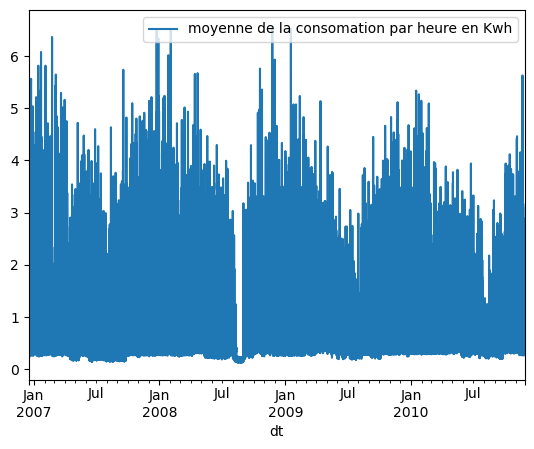

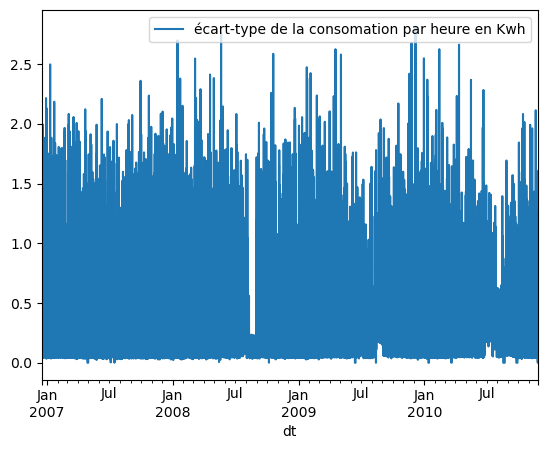

In [5]:
df_mean_std=df['Global_active_power'].resample('h').agg(['mean','std'])
plt.figure()
df_mean_std['mean'].plot(label='moyenne de la consomation par heure en Kwh')
plt.legend()
plt.figure()
df_mean_std['std'].plot(label='écart-type de la consomation par heure en Kwh')
plt.legend()
plt.show()

True
torch.Size([44260, 10, 1]) torch.Size([44260, 1])
torch.Size([6916, 10, 1]) torch.Size([6916, 1])
torch.Size([6916, 10, 1]) torch.Size([6916, 1])


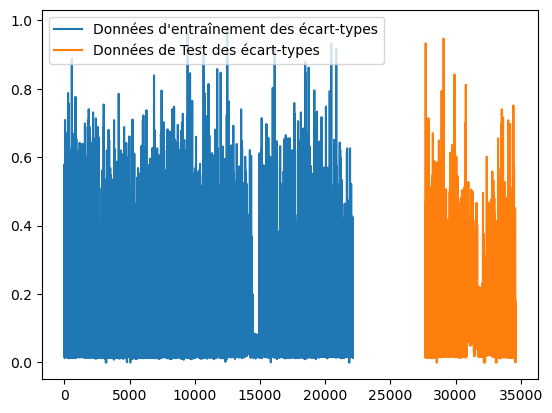

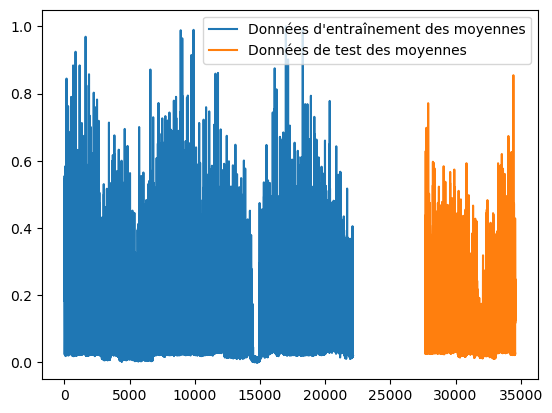

In [6]:
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
print(torch.cuda.is_available())
consumption_data_mean=df_mean_std['mean'].values
consumption_data_std=df_mean_std['std'].values

scaler_mean = MinMaxScaler()
scaler_std = MinMaxScaler()

consumption_data_mean = scaler_mean.fit_transform(consumption_data_mean.reshape(-1, 1))
consumption_data_std = scaler_std.fit_transform(consumption_data_std.reshape(-1, 1))

def create_sequences(data, seq_length):
    sequences = []
    labels=[]
    for i in range(len(data) - seq_length):
        sequence = data[i+seq_length:i:-1]
        sequences.append(sequence)
        labels.append(data[i+seq_length])
    return np.array(sequences),np.array(labels)

seq_length =10 

sequences_means,labels_mean = create_sequences(consumption_data_mean, seq_length)
sequences_std,labels_std = create_sequences(consumption_data_std, seq_length)

train_val_size_std = int(0.8 * len(sequences_std))
X_train_val_std, y_train_val_std = sequences_std[:train_val_size_std],labels_std[:train_val_size_std]
X_test_std,y_test_std = sequences_std[train_val_size_std:],labels_std[train_val_size_std:]

train_size_std = int(0.8 * len(X_train_val_std))
X_train_std,y_train_std=sequences_std[:train_size_std],labels_std[:train_size_std]
X_val_std,y_val_std=sequences_std[train_size_std:train_val_size_std],labels_std[train_size_std:train_val_size_std]

# On plot les ensemble pour montrer qu'ils sont différents et qu'ils représentent des partie disjointes du set de données

plt.figure()
plt.plot(y_train_std,label="Données d'entraînement des écart-types")
# plt.plot(range(len(y_train_std),len(y_train_std)+len(y_val_std)),y_val_std,label="Données de validation des écart-types")
plt.plot(range(len(y_train_std)+len(y_val_std),len(y_train_std)+len(y_val_std)+len(y_test_std)),y_test_std,label="Données de Test des écart-types")
plt.legend()

# Ici, on fait la moyenne de tous les éléments et non pas de chaque séquences car sinon on aurait un problème de taille 
# lorsqu'on voudrait retrancher le vecteur moyenne de X_train à X_val, au début on faisait les normalisation de X_val 
# et X_train de manière indépendante ...

m=np.mean(X_train_std)
std=np.std(X_train_std)
X_train_std=(X_train_std-m)/std

X_val_std=(X_val_std-m)/std


m=np.mean(y_train_std)
std=np.std(y_train_std)
y_train_std=(y_train_std-m)/std

y_val_std=(y_val_std-m)/std


train_val_size_mean = int(0.8 * len(sequences_means))
X_train_val_mean, y_train_val_mean = sequences_means[:train_val_size_mean],labels_mean[:train_val_size_mean]
X_test_mean,y_test_mean = sequences_means[train_val_size_mean:],labels_mean[train_val_size_mean:]

train_size_mean = int(0.8 * len(X_train_val_mean))
X_train_mean,y_train_mean=sequences_means[:train_size_mean],labels_mean[:train_size_mean]
X_val_mean,y_val_mean=sequences_means[train_size_mean:train_val_size_mean],labels_mean[train_size_mean:train_val_size_mean]

plt.figure()
plt.plot(y_train_mean,label="Données d'entraînement des moyennes")
# plt.plot(range(len(y_train_mean),len(y_train_mean)+len(y_val_mean)),y_val_mean,label="Données de validation des moyennes")
plt.plot(range(len(y_train_mean)+len(y_val_mean),len(y_train_mean)+len(y_val_mean)+len(y_test_mean)),y_test_mean,label="Données de test des moyennes")
plt.legend()

m=np.mean(X_train_mean)
std=np.std(X_train_mean)
X_train_mean=(X_train_mean-m)/std

X_val_mean=(X_val_mean-m)/std


m=np.mean(y_train_mean)
std=np.std(y_train_mean)
y_train_mean=(y_train_mean-m)/std

y_val_mean=(y_val_mean-m)/std

X_train,y_train=np.concatenate((X_train_mean,X_train_std),axis=0),np.concatenate((y_train_mean,y_train_std),axis=0)
X_val,y_val=np.concatenate((X_val_mean,X_val_std),axis=0),np.concatenate((y_val_mean,y_val_std),axis=0)



X_train,y_train = torch.FloatTensor(X_train),torch.FloatTensor(y_train)
X_val,y_val=torch.FloatTensor(X_val),torch.FloatTensor(y_val)
X_test_mean,y_test_mean = torch.FloatTensor(X_test_mean),torch.FloatTensor(y_test_mean)
X_test_std,y_test_std = torch.FloatTensor(X_test_std),torch.FloatTensor(y_test_std)

print(X_train.shape,y_train.shape)
print(X_test_mean.shape,y_test_mean.shape)
print(X_test_std.shape,y_test_std.shape)


batch_size = 32  
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False,drop_last=True)

In [9]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,input_size: int, rnn_hidden_size: int,num_stack_layers:int):
        super(RNN, self).__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.num_stack_layers=num_stack_layers
        self.rnn = nn.LSTM(input_size, rnn_hidden_size,num_stack_layers, batch_first=True)
        self.layers=   nn.Sequential(   nn.ReLU(),
                                        nn.Linear(rnn_hidden_size, 2*rnn_hidden_size),
                                        nn.Dropout(0.5),
                                        nn.ReLU(),
                                        nn.Linear(2*rnn_hidden_size,1))
        

    def forward(
        self, X: torch.Tensor
    ):
        
        h0=torch.zeros(num_stack_layers,X.size(0),self.rnn_hidden_size)
        c0=torch.zeros(num_stack_layers,X.size(0),self.rnn_hidden_size)        
        out,_= self.rnn(X, (h0, c0))
        print(out.shape)
        out = self.layers(out[:,-1,:])
        return out





In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparamètres, on a augmenté le nombre d'époques parce qu'avec 5 époques on pouvait avoir des résultats très bon 
# comme moyen, par contre on a vaiment réussi à avoir 4% d'erreur en 5 époques !!! (avec surement beaucoup de réussite) 
input_size = 1 
hidden_size = 32  
num_epochs = 30
learning_rate = 0.001
num_stack_layers=2

model = RNN(input_size, hidden_size,num_stack_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Entraînement du modèle
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0 
    for inputs, labels in train_loader:
        output=model(inputs)
        loss=criterion(output,labels)
        total_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()            
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}')

# Évaluation du modèle
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            output=model(inputs)
            loss=criterion(output,labels)
            test_loss+=loss.item()
        print(f'Test Loss: {test_loss/len(val_loader)}')

torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])


torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])


torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])


torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])


torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])


torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])


torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])


torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])


torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])
torch.Size([32, 10, 32])


KeyboardInterrupt: 

Error std: 4.9860687255859375%
Error mean: 4.6826300621032715%


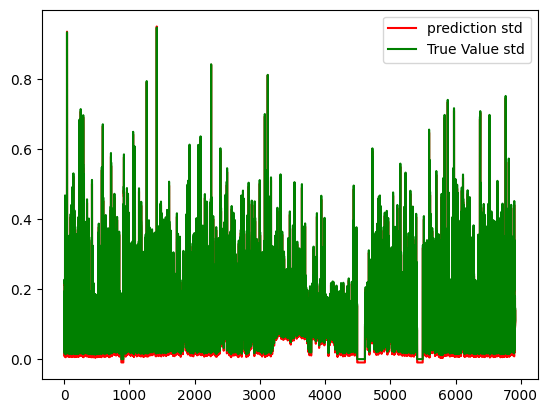

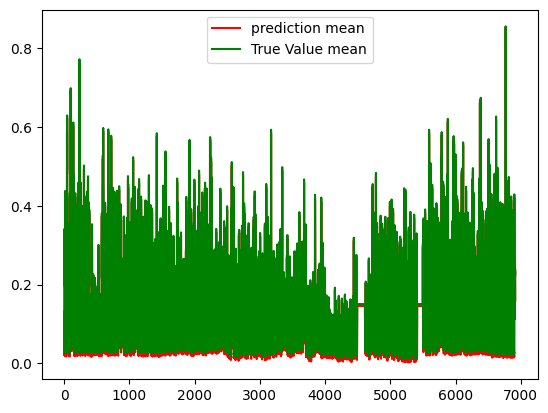

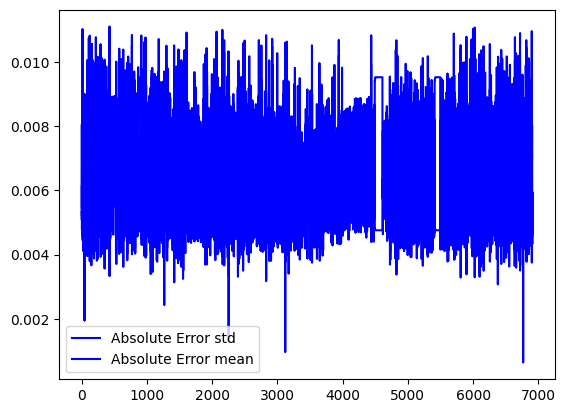

In [8]:
model.eval()
with torch.no_grad():
    predicted_std=model(X_test_std).numpy()
    predicted_mean=model(X_test_mean).numpy()

fin=-1
plt.figure()
plt.plot(predicted_std[:fin],label='prediction std',color='r')
plt.legend()

# plt.figure()
plt.plot(y_test_std[:fin],label='True Value std',color='green')
plt.legend()



plt.figure()
plt.plot(predicted_mean[:fin],label='prediction mean',color='r')
plt.legend()

# plt.figure()
plt.plot(y_test_mean[:fin],label='True Value mean',color='green')
plt.legend()



plt.figure()
plt.plot(np.abs(y_test_std[:fin]-predicted_std[0:fin]),label='Absolute Error std',color='b')
plt.plot(np.abs(y_test_mean[:fin]-predicted_mean[0:fin]),label='Absolute Error mean',color='b')
plt.legend()

print(f"Error std: {(torch.mean(np.abs(y_test_std[:fin]-predicted_std[:fin])))/torch.mean(y_test_std[:fin])*100}%")
print(f"Error mean: {(torch.mean(np.abs(y_test_mean[:fin]-predicted_mean[:fin])))/torch.mean(y_test_mean[:fin])*100}%")

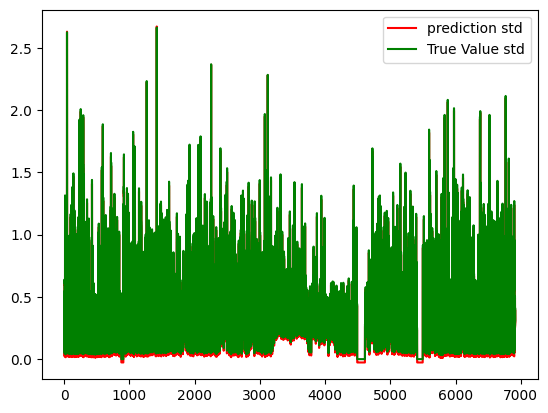

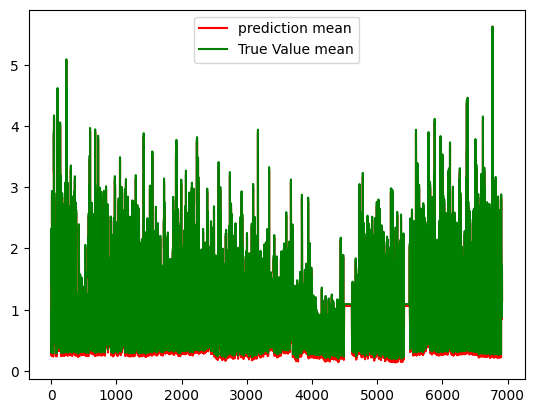

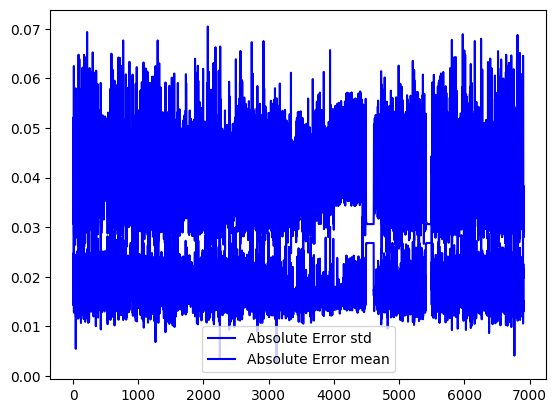

Error std: 4.986068689151879%
Error mean: 4.106787461668121%


In [9]:
y_mean_predict=scaler_mean.inverse_transform(predicted_mean)
y_std_predict=scaler_std.inverse_transform(predicted_std)
y_mean=scaler_mean.inverse_transform(y_test_mean)
y_std=scaler_std.inverse_transform(y_test_std)


fin=-1
plt.figure()
plt.plot(y_std_predict[:fin],label='prediction std',color='r')
plt.legend()

# plt.figure()
plt.plot(y_std[:fin],label='True Value std',color='green')
plt.legend()



plt.figure()
plt.plot(y_mean_predict[:fin],label='prediction mean',color='r')
plt.legend()

# plt.figure()
plt.plot(y_mean[:fin],label='True Value mean',color='green')
plt.legend()



plt.figure()
plt.plot(np.abs(y_std[:fin]-y_std_predict[0:fin]),label='Absolute Error std',color='b')
plt.plot(np.abs(y_mean[:fin]-y_mean_predict[0:fin]),label='Absolute Error mean',color='b')
plt.legend()
plt.show()

print(f"Error std: {(np.mean(np.abs(y_std[:fin]-y_std_predict[:fin])))/np.mean(y_std[:fin])*100}%")
print(f"Error mean: {(np.mean(np.abs(y_mean[:fin]-y_mean_predict[:fin])))/np.mean(y_mean[:fin])*100}%")